# Bayesian Inference - Basics
Description of bayesian inference. Equation. etc.

...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy import interpolate, integrate, stats
import ipywidgets as widgets

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Data
The data consists of 5 points that closely follow a linear trend, with zero y-intercept and slope 3. Each datapoint is treated as a random variable, and the points shown here corresponds to the mean. The distribution of each datapoint will be described in the 'Likelihood' section.

In [3]:
Nd = 5
max_x = 10.
slope = 3.
#noise_factor = 2.
#xd = np.random.random(Nd)*max_x
#yd = slope*xd + np.random.random(Nd)*xd*noise_factor - xd*noise_factor/2.
xd = np.array([ 2.71423329,  4.25077341,  7.28563119,  8.25131288,  9.26264237 ])
yd = np.array([ 7.45112287, 15.63959515, 18.13168553, 27.53369572, 27.67914196 ])

<IPython.core.display.Javascript object>


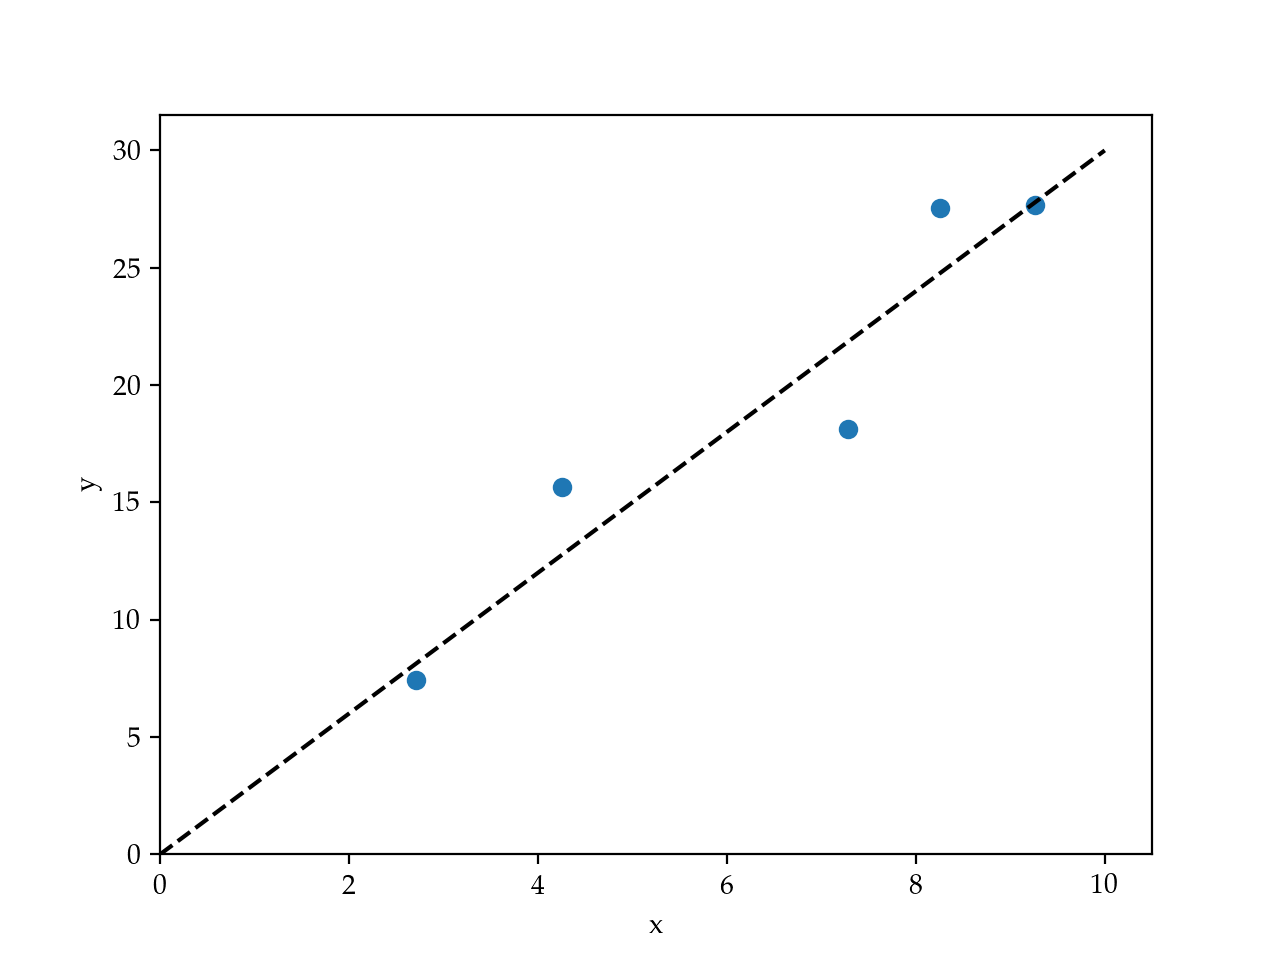

(0.0, 31.5)

In [4]:
xm = np.array([0, max_x])
ym = slope*xm
plt.figure()
plt.plot(xd, yd, 'C0o')
plt.plot(xm, ym, 'k--')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

## Model
We model this relationship with a one parameter model. The goal will be to determine the value of that parameter.
The model is a linear model with zero intercept, and the parameter is the slope of the line.

In [5]:
def model(w, x):
    w = np.atleast_1d(w)
    x = np.atleast_1d(x)
    y = w[:,None]*x[None,:]
    return np.squeeze(y)

## Likelihood - Interactive
The likelihood of the model given the new data is equal to the probability that the data came from the model.
We will model the data as random variables with gaussian distribution, mean equal to the data value, and standard deviation equal to twenty percent of the mean. The likelihood of the model given a single data point is the probability that the data has the value given by the model for the x-location of the datapoint. The likelihood for a collection of data point is given as the product of the likelihood of each point. This value is normalized by the integral of the likelihood of all  possible models to get a probability distribution with integral equal to one. This result is the likelihood of each parameter given that the model has the form chosen.

In this interactive widget each data point distribution is plotted, as is the model. The value of the parameter can be adjusted. The probability that each data point came from the given model is also displayed. As the value of the parameter is adjusted, the corresponding point in the likelihood plot is also shown.

In [6]:
w_min = 0.
w_max = 10.
Nw = 1001
error = 0.2
Npdfpts = 21

In [7]:
def likelihood(w, xd=xd, yd=yd, error=0.2):
    mean = yd
    stddev = error * mean
    ymd = model(w, xd)
    lld = 1./np.sqrt(2.*np.pi*stddev[None,:]**2) * \
        np.exp(-1.*((ymd-mean[None,:])**2)/(2.*stddev[None,:]**2))
    return np.prod(lld, axis=1)

In [9]:
W = np.linspace(w_min, w_max, Nw)
llhd_i = likelihood(W, xd, yd, error)
llhd = interpolate.interp1d(W, llhd_i, kind='linear')
llhd_int = integrate.quad(llhd, w_min, w_max)[0]

<IPython.core.display.Javascript object>


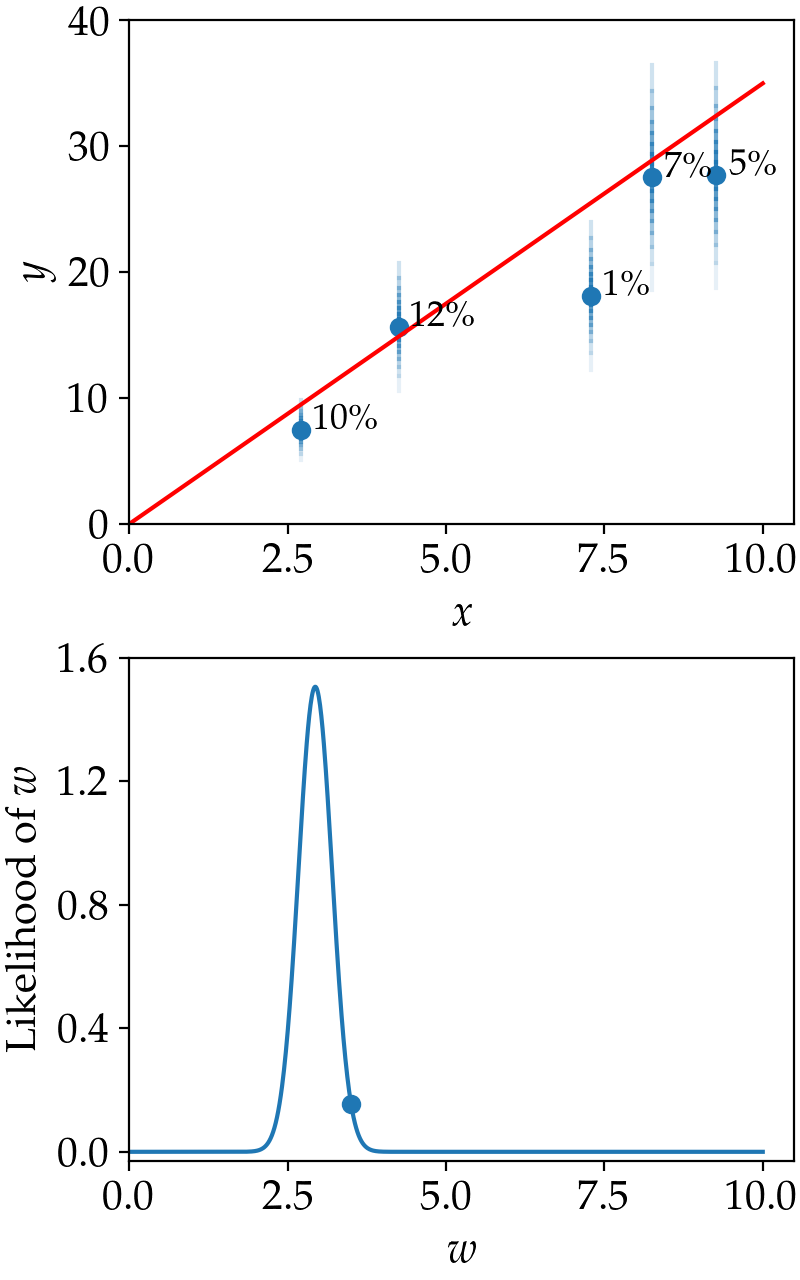

In [157]:
# initialize plot
fig = plt.figure(figsize=(4, 6.4))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

#plot data and data PDFs
mean = yd
stddev = error * mean
ppts = np.linspace(0,1,Npdfpts-1)
ppts = np.append(ppts,1.)
norms = []
for i in range(Nd):
    norm = stats.norm(loc=mean[i], scale=stddev[i])
    norms.append(norm)
    xp = [xd[i]]*2
    for j in range(Npdfpts-1):
        yp = [norm.ppf(ppts[j]), norm.ppf(ppts[j+1])]
        alpha = (0.5-np.abs(ppts[j]-0.5))/0.5
        ax1.plot(xp, yp, 'C0-', alpha=alpha)
ax1.plot(xd, yd, 'C0o')
ax1.set_xlim(0,10.5)
ax1.set_ylim(0,40)
ax1.set_yticks([0,10,20,30,40])
ax1.set_xlabel(r'$x$',fontsize=15)
ax1.set_ylabel(r'$y$',fontsize=15)

# plot initial model
# winit = w_min
winit = 3.5
ym = model(winit, xm)
line, = ax1.plot(xm, ym,'r-')

# Annotate data likelihood
annotation = []
ymd = model(winit, xd)
for i,xy in enumerate(zip(xd+0.2, yd)):
    ann = norms[i].pdf(ymd[i])*100.
    annotation.append(ax1.annotate(r'${:3.0f}\%$'.format(ann), xy=xy, textcoords='data',fontsize=13))

# Plot Likelihood    
ax2.plot(W, llhd_i/llhd_int, 'C0-')
point, = ax2.plot(winit, likelihood(winit)/llhd_int, 'C0o')
ax2.set_xlim(0,10.5)
ax2.set_ylim(-0.03,1.6)
ax2.set_yticks([0,0.4,0.8,1.2,1.6])
ax2.set_xlabel(r'$w$',fontsize=15)
ax2.set_ylabel(r'Likelihood of $w$',fontsize=15)
    
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

fig.tight_layout(pad=0.2)
plt.savefig('../figs-new/likelihood_3p5.pdf',bbox_inches='tight')
plt.show()

# # Widget 
# def update(w = winit):
#     ym = model(w, xm)
#     line.set_ydata(ym)
#     point.set_xdata(w)
#     point.set_ydata(likelihood(w)/llhd_int)
#     ymd = model(w, xd)
#     for i in range(Nd):
#         ann = norms[i].pdf(ymd[i])*100.
#         annotation[i].set_text('{:3.0f}%'.format(ann))
#     fig.canvas.draw()
# widgets.interact(update, w=(w_min,w_max,0.1));

## Prior and Posterior - Interactive
The prior is our current belief regarding the value of the parameter.
We consider several priors:

    0 - The slope is equally likely to have any value.
    
    1 - The slope is equally likely to have any value between 1 and 3, with any other values being impossible.
    
    2 - The slope is most likely to be 2, with probability of other values given by a Gaussian distribution.
    
    3 - The slope is 2, with any other values being impossible. 

The posterior is the result of modifying our current belief (prior) based on the data. The posterior is the product of the likelihood (data) and the prior. The value at each w is normalized by the integral of this product to make the intregral of the posterior be 1. 


In this widget 4 different priors can be chosen. These examples show that:

    * when we have no belief (case 0) the posterior = the data. This reduces to the Maximum Likelihood Estimate.
    * when our beleif is absolute (case 2) the posterior = the prior regardless of the data
    * when we have a balance between strong beleif and flexibility the posterior depends on both the data and prior.

In [150]:
case_init = 0
case_name = ['noninformed-prior','tophat-prior','Gaussian-prior','Fixed-prior']
y_lim = 2.6
y_inf = 10
Nc = 4

In [151]:
def prior(w, case, w_min=w_min, w_max=w_max):
    if case==0:
        return 1./(w_max-w_min)*(w>=w_min and w<=w_max)
    elif case==1:
        w_min = 1.
        w_max = 3.
        return 1./(w_max-w_min)*(w>w_min and w<=w_max)
    elif case==2:
        return stats.norm(loc=2., scale=0.5).pdf(w)
    elif case==3:
        return (w==2.)*1.

In [152]:
prior_i = np.array([prior(W[i], case_init) for i in range(Nw)])

In [153]:
dw = W[1]-W[0]
post = np.ones([Nc, Nw])
for ic in range(Nc):
    mld = 0
    for i,w in enumerate(W):
        post[ic,i] = llhd_i[i]*prior(w, ic)
        mld += post[ic,i]*dw
    post[ic,:] /= mld
post[post>y_inf] = 1.

<IPython.core.display.Javascript object>


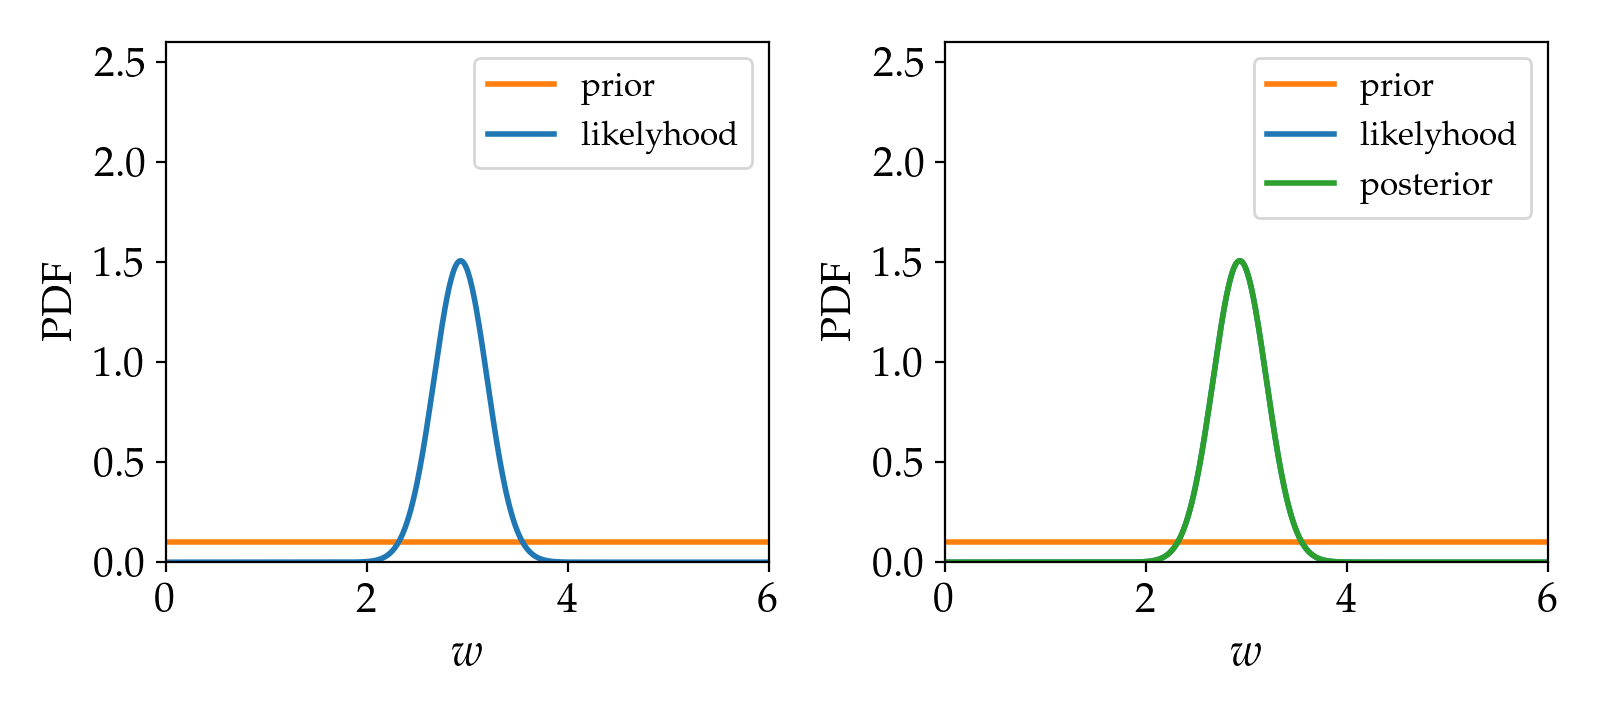

In [154]:
fig = plt.figure(figsize=(8,3.6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel(r'$w$',fontsize=16)
ax1.set_ylabel('PDF',fontsize=15)
ax1.set_xlim([w_min, 0.6*w_max])
ax1.set_ylim([0.,y_lim])
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel(r'$w$',fontsize=16)
ax2.set_ylabel('PDF',fontsize=15)
ax2.set_xlim([w_min, 0.6*w_max])
ax2.set_ylim([0.,y_lim])

line1, = ax1.plot(W, prior_i, 'C1-', label='prior', linewidth=2)
ax1.plot(W, llhd_i/llhd_int, 'C0-', label='likelyhood', linewidth=2)
ax1.legend(fontsize=12)
line2, = ax2.plot(W, prior_i, 'C1-', label='prior', linewidth=2)
ax2.plot(W, llhd_i/llhd_int, 'C0-', label='likelyhood', linewidth=2)
line3, = ax2.plot(W, post[case_init, :], 'C2-', label='posterior', linewidth=2)
ax2.legend(fontsize=12)

ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

fig.tight_layout(pad=1.5)
plt.savefig('../figs-new/{}.pdf'.format(case_name[case_init]),bbox_inches='tight')
plt.show()

# # Widget
# def update(case = case_init):
#     prior_i = np.array([prior(W[i], case) for i in range(Nw)])
#     line1.set_ydata(prior_i)
#     line2.set_ydata(prior_i)
#     line3.set_ydata(post[case, :])
#     fig.canvas.draw()
# widgets.interact(update, case={0:0,1:1,2:2,3:3});